# Understanding Factors in Animal Shelter Pet Adoption - Classification Models

In efforts to understand trends in pet adoption outcomes, the Austin Animal Center has provided data relating to the pets in their adoption center. Understanding this data and using it to model the factors that influence pet adoption could lead to recommendations that improve the performance of the center and help more pets find homes.

### Objective

In this project I will be building predictive models via the following tasks:

   1. Preparing and splitting the data set to develop and test the performance of predictive models
   2. Predicting whether or not, based on attributes provided in the data, an animal is likely to end up placed in a permanent home at the time it leaves the Austin Animal Center. (Yes (1) or No (0))
   2. Predicting which of the specific outcomes an animal will have based on attributes provided in the data. Outcome type classes include: Adoption, Transfer, Returned to Owner, Euthanasia and Death.
   
First I will begin by importing the necessary packages for analysis, as well as the dataset that was cleaned and formatted **[here](https://github.com/emenriquez/Springboard-Coursework/blob/master/Capstone%20Project%201/Data%20Wrangling%20-%20Pet%20Adoption%20V2.ipynb)**

In [1]:
# For working with dataframes and manipulation
import numpy as np
import pandas as pd

# Used to create and customize graphics/plots
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Used to work with datetime and timedelta objects
from datetime import datetime, timedelta

# for building classifier model predictions and result analysis
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import itertools

In [2]:
# Load the formatted dataset
data = pd.read_pickle('data/data_clean.pkl')

#  Remove any duplicate entries
data.drop_duplicates(inplace=True);

# Drop the columns that we will not be considering
data.drop(['Outcome Subtype', 'Animal ID', 'Date of Birth', 'Name'], axis=1, inplace=True)

# Change name column into has name, or has no name and the same for Secondary Color
data['Secondary Color'] = data['Secondary Color'].notnull()

# Extract only number of days from Age upon Outcome column
data['Age upon Outcome'] = data['Age upon Outcome'].dt.days//365.25

# Change Animal Type column into binary format True for Cat, False for Dog
data['Animal Type'] = (data['Animal Type'] == 'Cat')

# Rename Animal Type column to Cat
data.rename(columns={'Animal Type': 'Cat'}, inplace=True)

# Split Sex upon Outcome Category into OHE format for 5 categories: Intact/spayed female, Intact/Spayed male, unknown
data = data.join(pd.get_dummies(data['Sex upon Outcome']))
data.rename(columns={'Unknown': 'Unknown Gender'}, inplace=True)
data.drop('Sex upon Outcome', axis=1, inplace=True)

# Add Column denoting whether breed is mixed or not (Mixed=True, Pure=False)
data['Mixed Breed'] = data['Breed'].str.contains('Mix')

In [3]:
cats= data[data['Cat'] == True]
dogs= data[data['Cat'] == False]

# Generate Top 10 ranking breeds for cats by frequency
top10_cat_breeds = pd.DataFrame(data= {'Cat Breed': cats['Breed'].value_counts().index.values[:10],
                   '# of Cats': cats['Breed'].value_counts().values[:10]},
             columns = ['Cat Breed', '# of Cats'],
             index=range(1,11)
                    )

# Label the index as ranking
top10_cat_breeds.index.name = 'Rank'

# Display top10 rankings
print('10 Most Common Cat Breeds\n',top10_cat_breeds)
print('\nTotal Number of Distinct Cat Breeds: {0}'.format(len(cats['Breed'].unique())))
print('Fraction of Total Cats Occupied by 10 most common breeds: {:0.2f} %'.format(100*cats['Breed'].value_counts()[:10].sum()/cats['Breed'].value_counts().sum()))

# Generate most common ranking breeds for dogs by frequency
top_dog_breeds = pd.DataFrame(data= {'Dog Breed': dogs['Breed'].value_counts().index.values[:25],
                   '# of Dogs': dogs['Breed'].value_counts().values[:25]},
             columns = ['Dog Breed', '# of Dogs'],
             index=range(1,26)
                    )

# Label the index as ranking
top_dog_breeds.index.name = 'Rank'

# Display most dog breed rankings
print('\n\n25 Most Common Dog Breeds\n',top_dog_breeds)
print('\nTotal Number of Distinct Dog Breeds: {0}'.format(len(dogs['Breed'].unique())))
print('Fraction of Total Dogs Occupied by 25 most common breeds: {:0.2f} %'.format(100*dogs['Breed'].value_counts()[:25].sum()/dogs['Breed'].value_counts().sum()))

10 Most Common Cat Breeds
                      Cat Breed  # of Cats
Rank                                     
1       Domestic Shorthair Mix      22766
2     Domestic Medium Hair Mix       2257
3        Domestic Longhair Mix       1204
4                  Siamese Mix        997
5           Domestic Shorthair        378
6       American Shorthair Mix        194
7                 Snowshoe Mix        150
8         Domestic Medium Hair        127
9               Maine Coon Mix        103
10                    Manx Mix         85

Total Number of Distinct Cat Breeds: 55
Fraction of Total Cats Occupied by 10 most common breeds: 98.53 %


25 Most Common Dog Breeds
                       Dog Breed  # of Dogs
Rank                                      
1                  Pit Bull Mix       6283
2        Labrador Retriever Mix       5628
3       Chihuahua Shorthair Mix       5264
4           German Shepherd Mix       2239
5     Australian Cattle Dog Mix       1281
6                 Dachshund Mix 

In [4]:
# Reduce number of breeds to top 10 most common cat breeds and top 25 most common dog breeds
# Create 'Other' breed for all others
simple_breeds = []
for breed in data['Breed']:
    if breed in list(top10_cat_breeds['Cat Breed']):
        simple_breeds.append(breed)
    elif breed in list(top_dog_breeds['Dog Breed']):
        simple_breeds.append(breed)
    else:
        simple_breeds.append('Other')

# Add the Simple Breed Column into the dataset
data['Simple Breed'] = list(pd.Series(simple_breeds).map(lambda x: x.rstrip(' Mix')))

# Remove the original Breed Column
data.drop('Breed', axis=1, inplace=True)

In [5]:
# Reduce number of Primary Colors to top 10 most common cat and dog colors
# Create 'Other' color for all others
simple_colors = []
for color in data['Primary Color']:
    if color in list(cats['Primary Color'].value_counts().index[:10]):
        simple_colors.append(color)
    elif color in list(dogs['Primary Color'].value_counts().index[:10]):
        simple_colors.append(color)
    else:
        simple_colors.append('Other')

In [6]:
# Add the Simple Color Column into the dataset
data['Simple Color'] = simple_colors

# Remove the original Primary Color Column
data.drop('Primary Color', axis=1, inplace=True)

In [7]:
# Convert the simple color and simple breed columns into one-hot encoding format and combine them into the dataset
data = data.join(pd.get_dummies(data[['Simple Color', 'Simple Breed']]))
data.drop(['Simple Breed', 'Simple Color'], axis=1, inplace=True)

In [8]:
# Set the index of the dataset to be the DateTime column
data.set_index('DateTime', inplace=True);

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71535 entries, 2017-01-11 18:17:00 to 2014-12-23 18:18:00
Data columns (total 63 columns):
Found Home                            71535 non-null category
Outcome Type                          71535 non-null category
Cat                                   71535 non-null bool
Age upon Outcome                      71535 non-null int64
Secondary Color                       71535 non-null bool
Intact Female                         71535 non-null uint8
Intact Male                           71535 non-null uint8
Neutered Male                         71535 non-null uint8
Spayed Female                         71535 non-null uint8
Unknown Gender                        71535 non-null uint8
Mixed Breed                           71535 non-null bool
Simple Color_Black                    71535 non-null uint8
Simple Color_Blue                     71535 non-null uint8
Simple Color_Blue Tabby               71535 non-null uint8
Simple Color_Brown         

#### Data Split

In [56]:
# Split test set from data
X_temp, X_test, y_temp, y_test = train_test_split(data.drop(['Found Home', 'Outcome Type', 'Unknown Gender', 'Simple Color_Other', 'Simple Breed_Other'], axis = 1), data['Found Home'], test_size=0.2, random_state=42)

# Split remaining data into train and CV sets
X_train, X_CV, y_train, y_CV = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Verify train, CV and test sets
print('Number of training entries: {0} -> {1:.0f}% of data'.format(X_train.shape[0], 100*X_train.shape[0]/data.shape[0]))
print('Number of CV entries: {0} -> {1:.0f}% of data'.format(X_CV.shape[0], 100*X_CV.shape[0]/data.shape[0]))
print('Number of test entries: {0} -> {1:.0f}% of data'.format(X_test.shape[0], 100*X_test.shape[0]/data.shape[0]))

Number of training entries: 42921 -> 60% of data
Number of CV entries: 14307 -> 20% of data
Number of test entries: 14307 -> 20% of data


In [57]:
# Save formatted and split data for binomial model
X_train.to_pickle('data/binom_train_data.pkl')
X_CV.to_pickle('data/binom_CV_data.pkl')
X_test.to_pickle('data/binom_test_data.pkl')

y_train.to_pickle('data/binom_train_labels.pkl')
y_CV.to_pickle('data/binom_CV_labels.pkl')
y_test.to_pickle('data/binom_test_labels.pkl')

#### Binomial Classification: Home Found vs. No Home Found

In [58]:
# Select number of features for subset
K = 5
subset = SelectKBest(k = K)
subset.fit(X_train, y_train)

# Display selected subset features
pd.DataFrame(data = {'Subset Features': X_train.columns[subset.get_support()]})

,Subset Features
0,Cat
1,Intact Female
2,Intact Male
3,Neutered Male
4,Spayed Female


In [59]:
# Initialize list for CV_errors and logistic regression model (with normalization)
CV_scores = []
lm = LogisticRegression()

for K in range(1, len(X_train.columns) + 1):
    # Create best subset of K features
    subset = SelectKBest(k = K)
    subset.fit(X_train, y_train)
    X_train_subset = X_train[X_train.columns[subset.get_support()].values.tolist()]
    
    # Perform logistic regression on selected features
    fit = lm.fit(X_train_subset, y_train)
    predict = lm.predict(X_CV[X_train.columns[subset.get_support()].values.tolist()])
    
    # Calculate classification error
    score = f1_score(y_CV, predict*1)
    CV_scores.append(score)

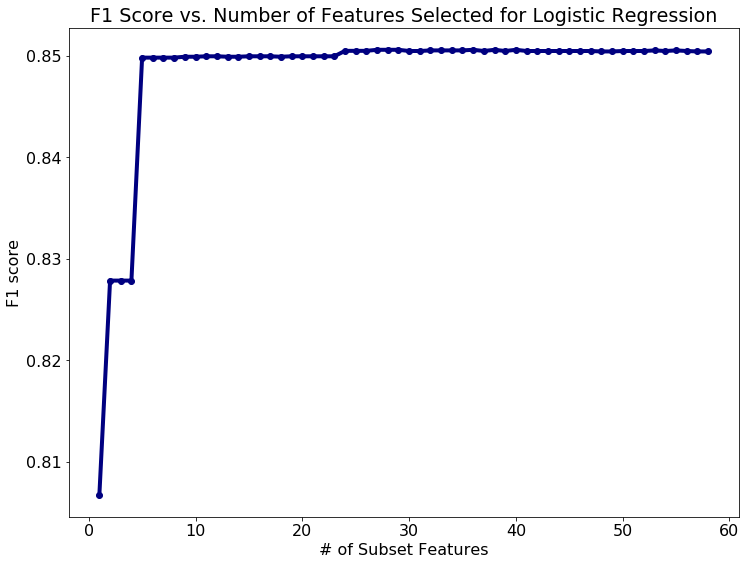

In [60]:
# Plot CV error vs. number of selected features
plt.figure(figsize = (12,9))
plt.plot(range(1, len(X_train.columns)+1),
         CV_scores,
         linewidth = 4,
         marker='o',
         c = 'Navy'
        )

# Plot formatting
plt.xlabel('# of Subset Features')
plt.ylabel('F1 score')
plt.title('F1 Score vs. Number of Features Selected for Logistic Regression')
plt.rcParams.update({'font.size': 18})

# Plot!
plt.show()

In [61]:
# Select number of features for subset
subset = SelectKBest(k = 1)
subset.fit(X_train, y_train)
X_train_subset = X_train[X_train.columns[subset.get_support()].values.tolist()]

# Perform logistic regression on selected features
fit = lm.fit(X_train_subset, y_train)
predict = lm.predict(X_CV[X_train.columns[subset.get_support()].values.tolist()])

#Generate Confusion Matrix
cnf_matrix = confusion_matrix(y_CV, predict)

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    NOTE: This code was sourced from Sci-kit learn documentation,
    see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for more details
    """

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

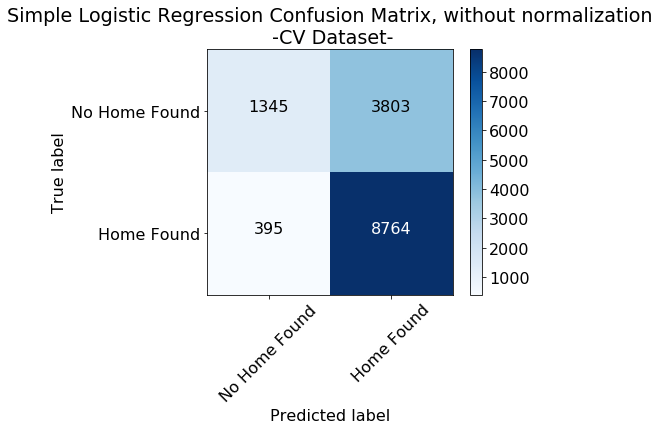

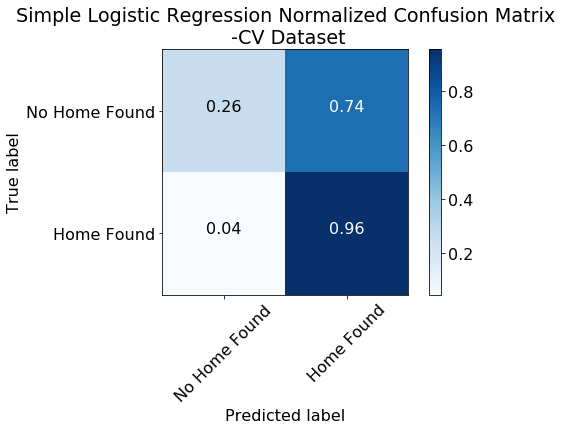

In [63]:
# Plot non-normalized confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['No Home Found', 'Home Found'],
                      title='Simple Logistic Regression Confusion Matrix, without normalization\n -CV Dataset-')

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['No Home Found', 'Home Found'],
                      normalize=True,
                      title='Simple Logistic Regression Normalized Confusion Matrix\n -CV Dataset')

plt.show()

In [64]:
# Select number of features for subset
subset = SelectKBest(k = 5)
subset.fit(X_train, y_train)
X_train_subset = X_train[X_train.columns[subset.get_support()].values.tolist()]

# Perform logistic regression on selected features
fit = lm.fit(X_train_subset, y_train)
predict = lm.predict(X_CV[X_train.columns[subset.get_support()].values.tolist()])

#Generate Confusion Matrix
cnf_matrix = confusion_matrix(y_CV, predict)

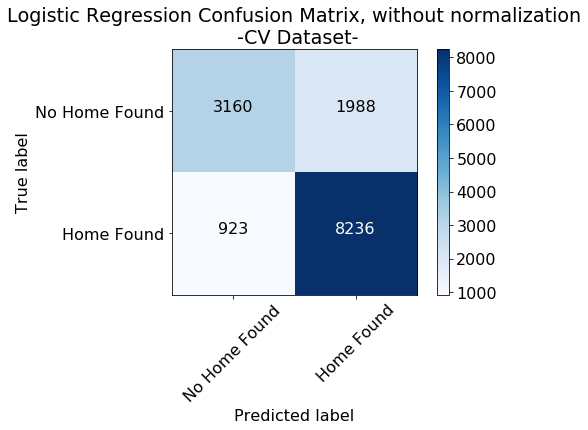

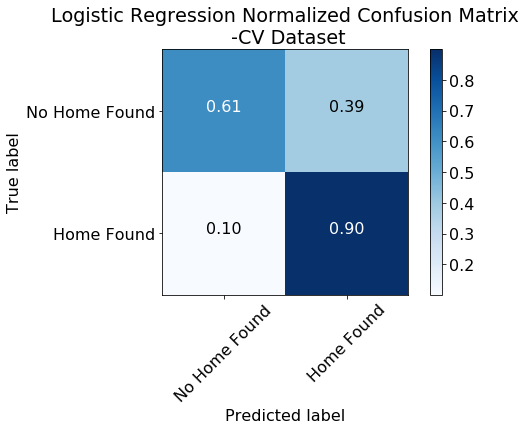

In [65]:
# Plot non-normalized confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['No Home Found', 'Home Found'],
                      title='Logistic Regression Confusion Matrix, without normalization\n -CV Dataset-')

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['No Home Found', 'Home Found'],
                      normalize=True,
                      title='Logistic Regression Normalized Confusion Matrix\n -CV Dataset')

plt.show()

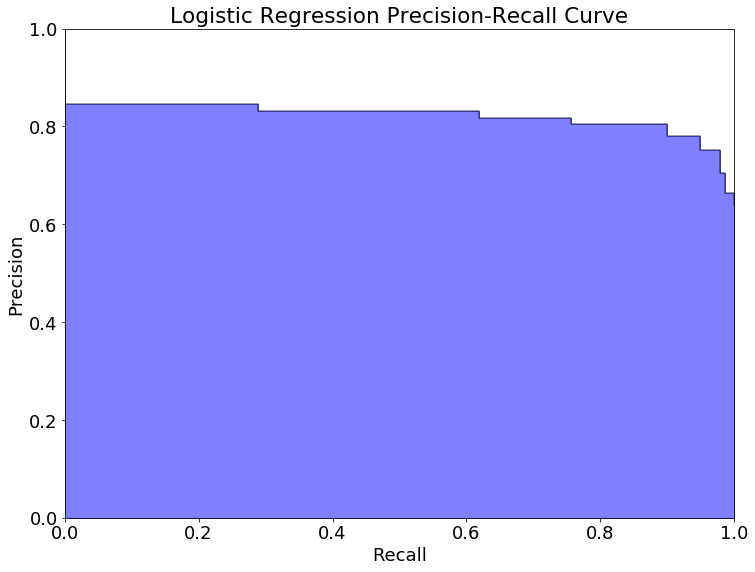

In [66]:
# Perform logistic regression on selected features
fit = lm.fit(X_train_subset, y_train)
predict = lm.predict_proba(X_CV[X_train.columns[subset.get_support()].values.tolist()])

# Generate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_CV, predict[:,1])

plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (12,9))
plt.step(recall, precision, color='k', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title('Logistic Regression Precision-Recall Curve')

plt.show()

In [67]:
F1_scores = []

for threshold in np.arange(0, 0.86, 0.01):
    CV_class = 1*(predict[:,1] >= threshold)
    F1_scores.append(f1_score(y_CV, CV_class))

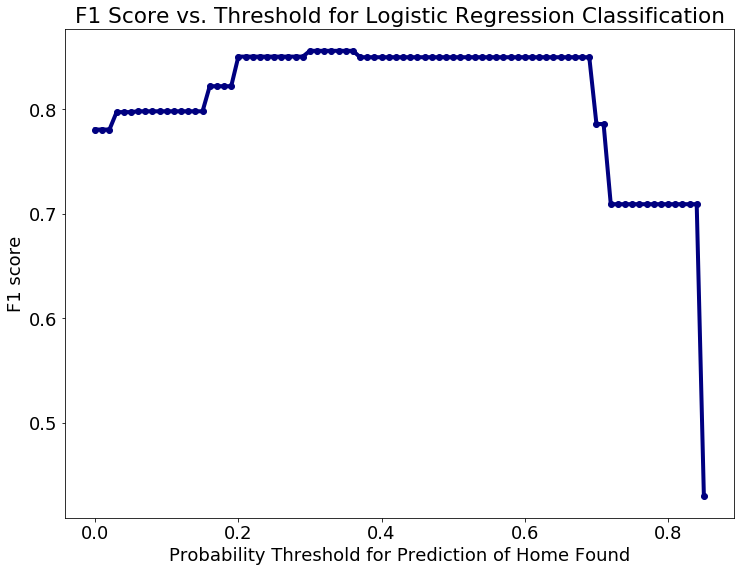

In [68]:
# Plot CV error vs. number of selected features
plt.figure(figsize = (12,9))
plt.plot(np.arange(0,0.86,0.01),
         F1_scores,
         linewidth = 4,
         c = 'Navy',
         marker='o'
        )

# Plot formatting
plt.xlabel('Probability Threshold for Prediction of Home Found')
plt.ylabel('F1 score')
plt.title('F1 Score vs. Threshold for Logistic Regression Classification')
plt.rcParams.update({'font.size': 18})

# Plot!
plt.show()

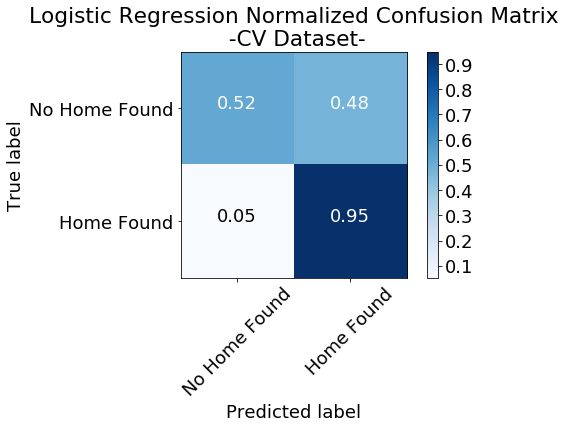

In [69]:
CV_class = 1*(predict[:,1] >= (np.argmax(F1_scores)*.01))
cnf_matrix = confusion_matrix(y_CV, CV_class)

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['No Home Found', 'Home Found'],
                      normalize=True,
                      title='Logistic Regression Normalized Confusion Matrix\n -CV Dataset-')

plt.show()

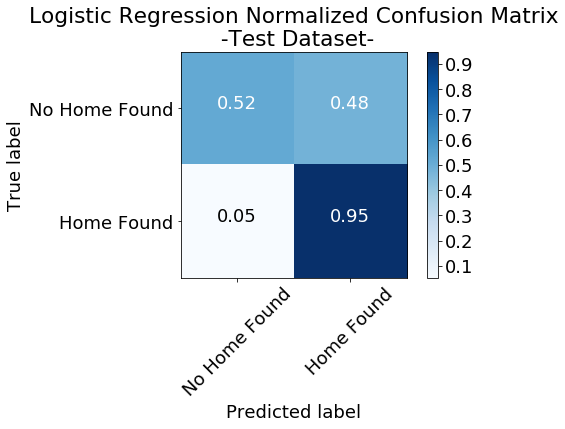

In [70]:
# Use the model to make predictions on the test set
predict = lm.predict_proba(X_test[X_train.columns[subset.get_support()].values.tolist()])

# Generate Confusion Matrix
test_class = 1*(predict[:,1] >= (np.argmax(F1_scores)*.01))
cnf_matrix = confusion_matrix(y_test, test_class)

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['No Home Found', 'Home Found'],
                      normalize=True,
                      title='Logistic Regression Normalized Confusion Matrix\n -Test Dataset-')

# Plot!
plt.show()

#### Random Forest Classifier

In [71]:
# Fit Random Forest Classifier using training dataset
rf = RandomForestClassifier(n_estimators=1000, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)
features = X_train.columns.values
print('------training done-------')

------training done-------


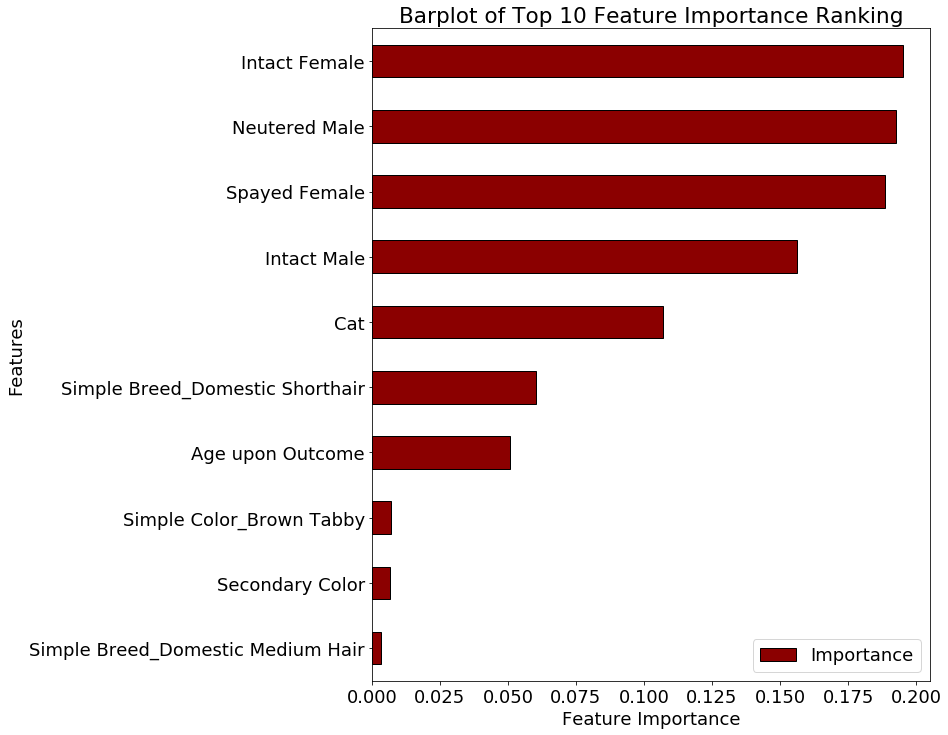

In [72]:
# create dataframe of feature importance rankings
importance_df2 = pd.DataFrame(
    data = {'features': features,
            'Importance': rf.feature_importances_
           }
).sort_values(by='Importance',
              ascending=True)

# Set the index for the importance dataframe
importance_df2.set_index('features', inplace=True)

# Generate horizontal bar plot
importance_df2[-10:].plot(kind='barh', figsize=(10, 12), facecolor='DarkRed', edgecolor='k')

# Plot formatting
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Barplot of Top 10 Feature Importance Ranking')

plt.show()

In [25]:
#Predict probability of Home Found
rf_proba = rf.predict_proba(X_CV)

In [26]:
F1_scores = []
for threshold in np.arange(0, 0.8, 0.01):
    CV_class = 1*(rf_proba[:,1] >= threshold)
    F1_scores.append(f1_score(y_CV, CV_class))
    
#Generate Confusion Matrix
CV_class = 1*(rf_proba[:,1] >= (np.argmax(F1_scores)*.01))
cnf_matrix = confusion_matrix(y_CV, CV_class)

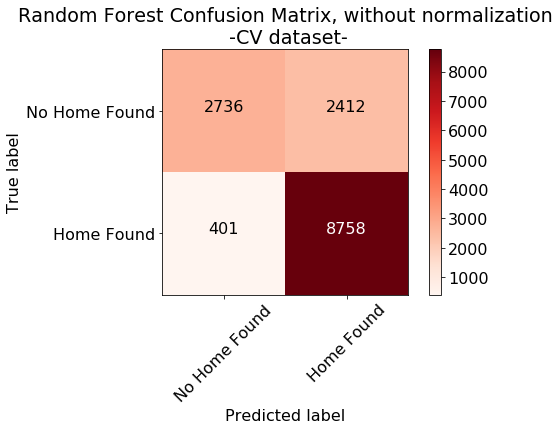

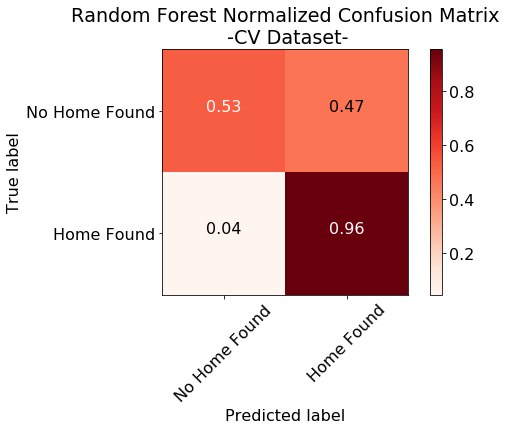

In [27]:
# Plot non-normalized confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['No Home Found', 'Home Found'],
                      title='Random Forest Confusion Matrix, without normalization\n -CV dataset-',
                      cmap='Reds'
                     )

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['No Home Found', 'Home Found'],
                      normalize=True,
                      title='Random Forest Normalized Confusion Matrix\n -CV Dataset-',
                      cmap='Reds'
                     )

plt.show()

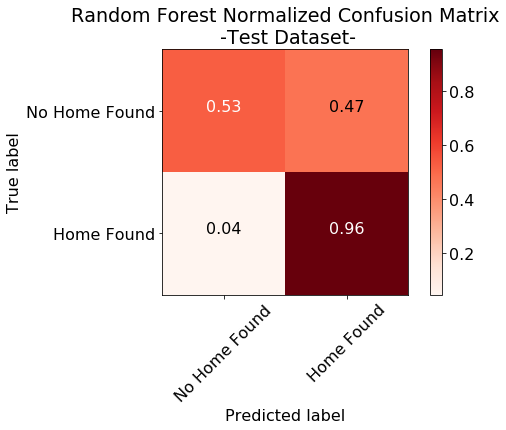

In [28]:
# Use the model to make predictions on the test set
rf_proba = rf.predict_proba(X_test)

# Generate Confusion Matrix
test_class = 1*(rf_proba[:,1] >= (np.argmax(F1_scores)*.01))
cnf_matrix = confusion_matrix(y_test, test_class)

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['No Home Found', 'Home Found'],
                      normalize=True,
                      title='Random Forest Normalized Confusion Matrix\n -Test Dataset-',
                      cmap='Reds'
                     )

# Plot!
plt.show()

### Predicting Outcome Type vs. Features

#### Data Split

In [73]:
# Split test set from data
X_temp, X_test, y_temp, y_test = train_test_split(data.drop(['Found Home', 'Outcome Type', 'Unknown Gender', 'Simple Color_Other', 'Simple Breed_Other'], axis = 1), data['Outcome Type'], test_size=0.2, random_state=42)

# Split remaining data into train and CV sets
X_train, X_CV, y_train, y_CV = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Verify train, CV and test sets
print('Number of training entries: {0} -> {1:.0f}% of data'.format(X_train.shape[0], 100*X_train.shape[0]/data.shape[0]))
print('Number of CV entries: {0} -> {1:.0f}% of data'.format(X_CV.shape[0], 100*X_CV.shape[0]/data.shape[0]))
print('Number of test entries: {0} -> {1:.0f}% of data'.format(X_test.shape[0], 100*X_test.shape[0]/data.shape[0]))

Number of training entries: 42921 -> 60% of data
Number of CV entries: 14307 -> 20% of data
Number of test entries: 14307 -> 20% of data


In [74]:
# Save formatted and split data for binomial model
X_train.to_pickle('data/multinom_train_data.pkl')
X_CV.to_pickle('data/multinom_CV_data.pkl')
X_test.to_pickle('data/multinom_test_data.pkl')

y_train.to_pickle('data/multinom_train_labels.pkl')
y_CV.to_pickle('data/multinom_CV_labels.pkl')
y_test.to_pickle('data/multinom_test_labels.pkl')

In [75]:
# Select number of features for subset
K = 5
subset = SelectKBest(k = K)
subset.fit(X_train, y_train)

# Display selected subset features
pd.DataFrame(data = {'Subset Features': X_train.columns[subset.get_support()]})

,Subset Features
0,Cat
1,Age upon Outcome
2,Intact Female
3,Intact Male
4,Simple Breed_Domestic Shorthair


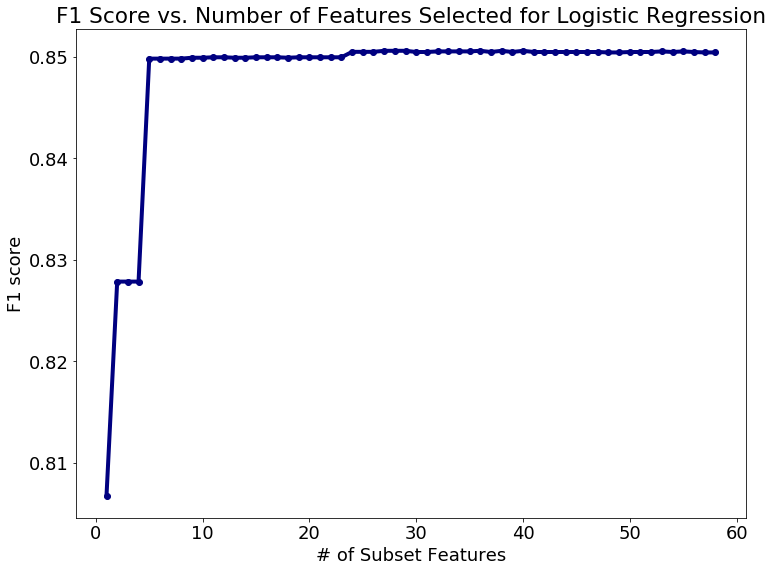

In [76]:
# Plot CV error vs. number of selected features
plt.figure(figsize = (12,9))
plt.plot(range(1, len(X_train.columns)+1),
         CV_scores,
         linewidth = 4,
         marker='o',
         c = 'Navy'
        )

# Plot formatting
plt.xlabel('# of Subset Features')
plt.ylabel('F1 score')
plt.title('F1 Score vs. Number of Features Selected for Logistic Regression')
plt.rcParams.update({'font.size': 18})

# Plot!
plt.show()

In [77]:
# Select number of features for subset
subset = SelectKBest(k = 5)
subset.fit(X_train, y_train)
X_train_subset = X_train[X_train.columns[subset.get_support()].values.tolist()]

# Perform logistic regression on selected features
fit = lm.fit(X_train_subset, y_train)
predict = lm.predict(X_CV[X_train.columns[subset.get_support()].values.tolist()])

#Generate Confusion Matrix
cnf_matrix = confusion_matrix(y_CV, predict)

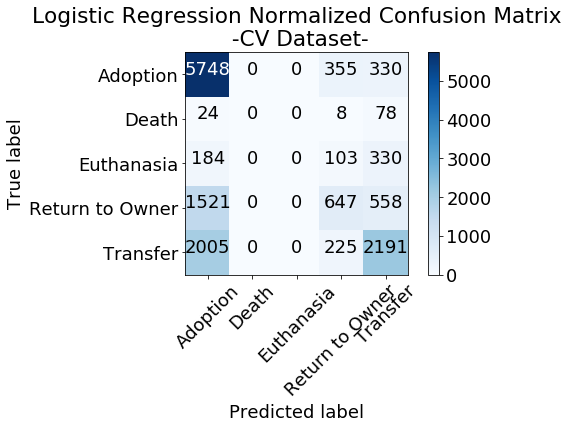

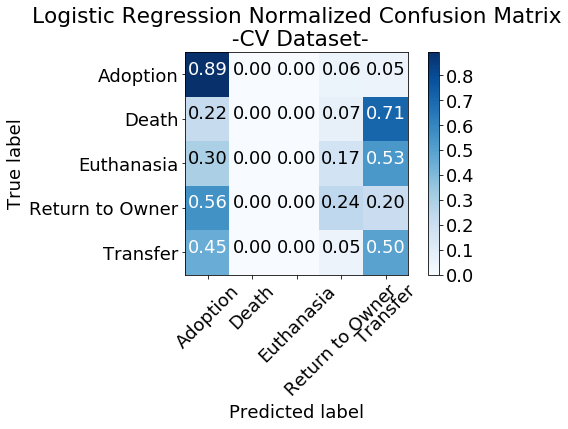

In [78]:
# Plot non-normalized and normalized confusion matrices
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Adoption', 'Death', 'Euthanasia', 'Return to Owner', 'Transfer'],
                      normalize=False,
                      title='Logistic Regression Normalized Confusion Matrix\n -CV Dataset-')

plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Adoption', 'Death', 'Euthanasia', 'Return to Owner', 'Transfer'],
                      normalize=True,
                      title='Logistic Regression Normalized Confusion Matrix\n -CV Dataset-')

plt.show()

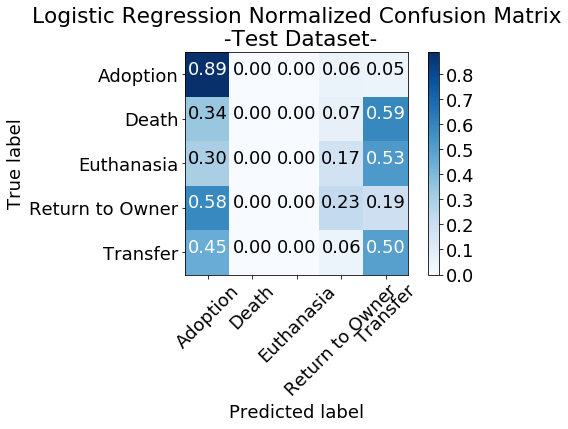

In [79]:
# Perform logistic regression on selected features for test set
fit = lm.fit(X_train_subset, y_train)
predict = lm.predict(X_test[X_train.columns[subset.get_support()].values.tolist()])

#Generate Confusion Matrix for test dataset
cnf_matrix = confusion_matrix(y_test, predict)

# Plot normalized confusion matrix for test dataset
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Adoption', 'Death', 'Euthanasia', 'Return to Owner', 'Transfer'],
                      normalize=True,
                      title='Logistic Regression Normalized Confusion Matrix\n -Test Dataset-')

plt.show()

#### Random Forest Classifier

In [80]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)
features = X_train.columns.values
print('------training done-------')

------training done-------


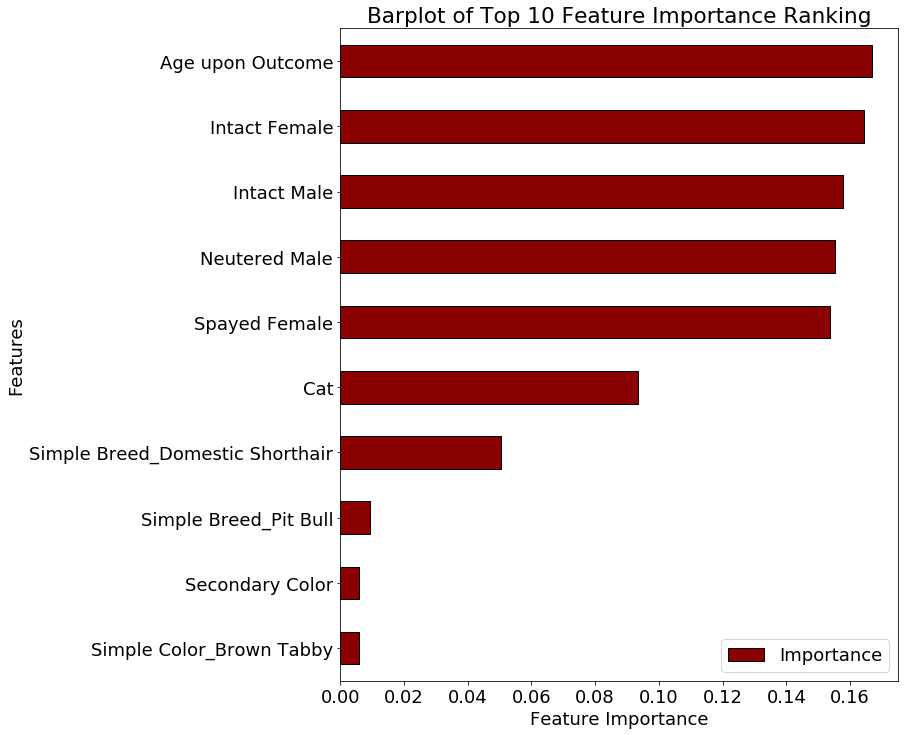

In [81]:
# create dataframe of feature importance rankings
importance_df = pd.DataFrame(
    data = {'features': features,
            'Importance': rf.feature_importances_
           }
).sort_values(by='Importance',
              ascending=False)

# create dataframe of feature importance rankings
importance_df2 = pd.DataFrame(
    data = {'features': features,
            'Importance': rf.feature_importances_
           }
).sort_values(by='Importance',
              ascending=True)

# Set the index for the importance dataframe
importance_df2.set_index('features', inplace=True)

# Generate horizontal bar plot
importance_df2[-10:].plot(kind='barh', figsize=(10, 12), facecolor='DarkRed', edgecolor='k')

# Plot formatting
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Barplot of Top 10 Feature Importance Ranking')

plt.show()

In [82]:
#Predict Outcome Type
rf_predict = rf.predict(X_CV)

cnf_matrix = confusion_matrix(y_CV, rf_predict)

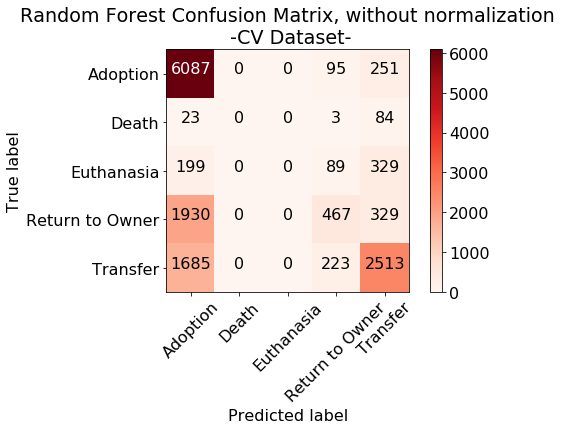

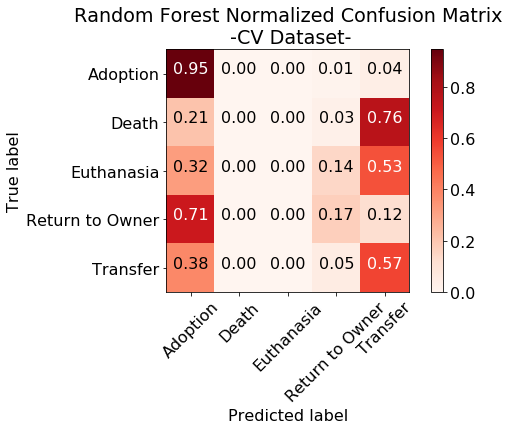

In [83]:
# Plot non-normalized confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Adoption', 'Death', 'Euthanasia', 'Return to Owner', 'Transfer'],
                      title='Random Forest Confusion Matrix, without normalization\n -CV Dataset-',
                      cmap='Reds'
                     )

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Adoption', 'Death', 'Euthanasia', 'Return to Owner', 'Transfer'],
                      normalize=True,
                      title='Random Forest Normalized Confusion Matrix\n -CV Dataset-',
                      cmap='Reds'
                     )

plt.show()

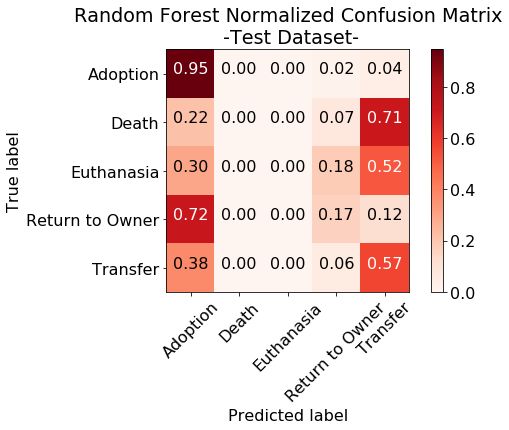

In [84]:
#Predict probability of Home Found
rf_proba = rf.predict(X_test)

cnf_matrix = confusion_matrix(y_test, rf_proba)

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Adoption', 'Death', 'Euthanasia', 'Return to Owner', 'Transfer'],
                      normalize=True,
                      title='Random Forest Normalized Confusion Matrix\n -Test Dataset-',
                      cmap='Reds'
                     )

plt.show()

# Additional Model Calculations

### 1. Adjusting Class weights for marginal classes

We can set the class weights to be inversely proportional to the fraction of total distribution that they occupy in the dataset.

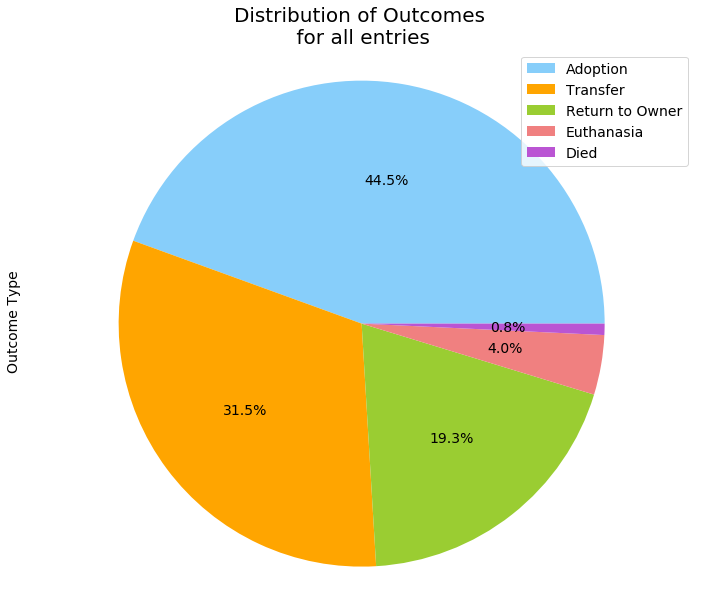

In [95]:
# Set figure and font size to visualize class distribution
plt.subplots(figsize=(12, 10))
plt.rc('font', size=14)

# Create pie chart for cat outcomes
ax = y_train.value_counts().plot(kind='pie',
                                         autopct='%1.1f%%',
                                         labels=None,
                                         legend=True,
                                         colors=['lightskyblue', 'orange', 'yellowgreen',  'lightcoral', 'mediumorchid']
                                        )

# plot formatting
plt.axis('equal')
plt.title('Distribution of Outcomes\n for all Entries', size=20)
plt.show()

In [105]:
# Set the class weights
class_weights = {'Adoption': 1./0.445, 'Transfer': 1./0.315, 'Return to Owner': 1./0.193, 'Euthanasia': 1./0.04, 'Died': 1./0.008}

# Run Random Forest with adjusted class weights
rf = RandomForestClassifier(n_estimators=1000, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0, class_weight = class_weights)
rf.fit(X_train, y_train)
features = X_train.columns.values
print('------training done-------')

------training done-------


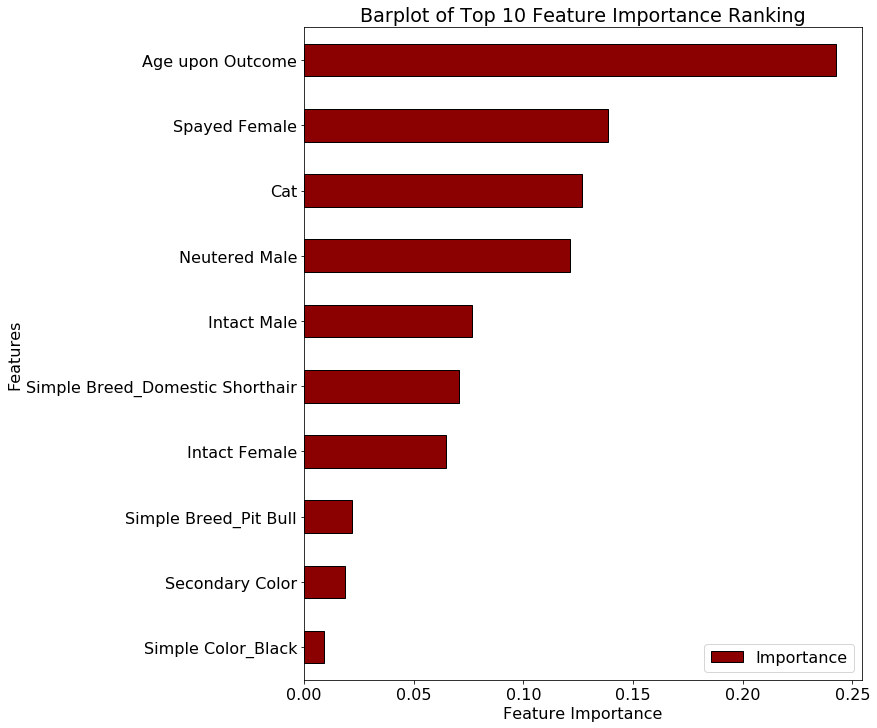

In [106]:
# create dataframe of feature importance rankings
importance_df = pd.DataFrame(
    data = {'features': features,
            'Importance': rf.feature_importances_
           }
).sort_values(by='Importance',
              ascending=False)

# create dataframe of feature importance rankings
importance_df2 = pd.DataFrame(
    data = {'features': features,
            'Importance': rf.feature_importances_
           }
).sort_values(by='Importance',
              ascending=True)

# Set the index for the importance dataframe
importance_df2.set_index('features', inplace=True)

# Generate horizontal bar plot
importance_df2[-10:].plot(kind='barh', figsize=(10, 12), facecolor='DarkRed', edgecolor='k')

# Plot formatting
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Barplot of Top 10 Feature Importance Ranking')

plt.show()

In [107]:
#Predict Outcome Type
rf_predict = rf.predict(X_CV)

cnf_matrix = confusion_matrix(y_CV, rf_predict)

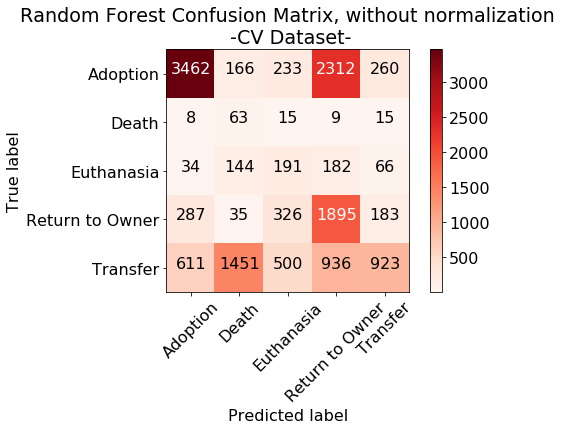

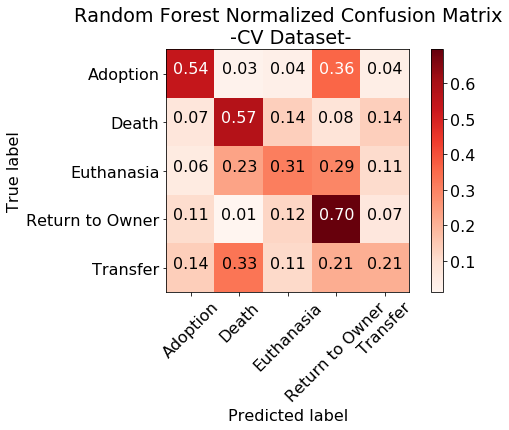

In [108]:
# Plot non-normalized confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Adoption', 'Death', 'Euthanasia', 'Return to Owner', 'Transfer'],
                      title='Random Forest Confusion Matrix, without normalization\n -CV Dataset-',
                      cmap='Reds'
                     )

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Adoption', 'Death', 'Euthanasia', 'Return to Owner', 'Transfer'],
                      normalize=True,
                      title='Random Forest Normalized Confusion Matrix\n -CV Dataset-',
                      cmap='Reds'
                     )

plt.show()

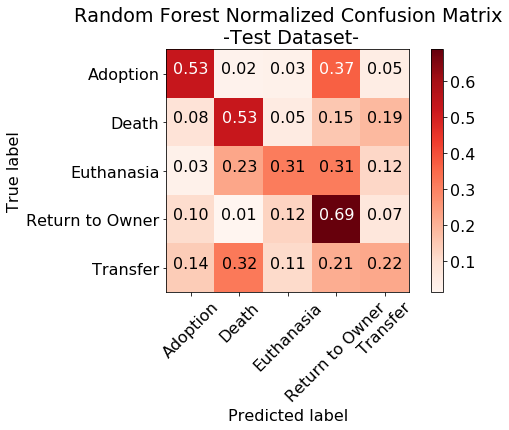

In [109]:
#Predict probability of Home Found
rf_proba = rf.predict(X_test)

cnf_matrix = confusion_matrix(y_test, rf_proba)

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Adoption', 'Death', 'Euthanasia', 'Return to Owner', 'Transfer'],
                      normalize=True,
                      title='Random Forest Normalized Confusion Matrix\n -Test Dataset-',
                      cmap='Reds'
                     )

plt.show()